In [ ]:
# Start writing code here...

In [ ]:
import sys
sys.path.append('..')

import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


from lib.viz import draw_missing_data_chart, draw_corr_heatmap, draw_components_variance_chart, biplot, draw_feature_importance, draw_histogram

from lib.transform_impute import *
from lib.split_data import group_split, train_test_split_single_level_index
from lib.create_pipeline import create_transformation_pipeline
from lib.read_data import read_feature_files, read_and_join_output_file

from lib.supervised_tuning import predict_score_base_regressors
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor

%matplotlib inline


/shared-libs/python3.9/py/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
all_features_target_df = read_and_join_output_file(start_year=2014, end_year=2021)
print(all_features_target_df.shape)

(3824, 81)


### Study the target variables

##### Shortage

In [ ]:
#To  enable us to view the township and range in the hover tooltip, make a subset of the dataframe

shortage_subset_df = all_features_target_df[['SHORTAGE_COUNT', 'GSE_GWE']].copy()
shortage_subset_df = shortage_subset_df.reset_index()

 

**Observed** 

T21SR28E reports most shortage during the severe drought years of 2014 and 2015 followed by T21SR27E.



In [ ]:
_deepnote_run_altair(shortage_subset_df, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"color":{"field":"TOWNSHIP_RANGE","scale":{"type":"linear","zero":false},"sort":null,"type":"nominal"},"x":{"field":"YEAR","scale":{"type":"linear","zero":false},"sort":null,"type":"nominal"},"y":{"field":"SHORTAGE_COUNT","scale":{"type":"linear","zero":true},"sort":null,"type":"quantitative"}},"height":220,"mark":{"tooltip":{"content":"data"},"type":"bar"}}""")

alt.Chart(...)

##### Groundwater levels

- Observed below: a dip in the groundwater levels from 2014 through 2016, the drought years, 
- then an increase until 2020 and followed by a drop in 2021, another sever drought year.

In [ ]:
_deepnote_run_altair(shortage_subset_df, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"point","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"YEAR","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"GSE_GWE","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"color":{"field":"TOWNSHIP_RANGE","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

### Set random state seed for consistency and reproducibility

- Use this random seed for preprocessinf 

In [ ]:
RANDOM_SEED = 42

### Split the data into train and test 

-  So that we only transform the test data and there is no data leakage


We will use the years 2014-2020 as the train set and the year 2021 as the test set. There are features in the year 2021 that are missing and so we will combine the two sets to have available to us **past** years data to forward fill the features in the impute test set. The key is that we are not in the learning task here, and this holdout set is the future set, so we are not leaking information back into the past.

In [ ]:
feature_columns = [col for col in all_features_target_df.columns if col not in ['TOWNSHIP_RANGE', 'YEAR', "GSE_GWE", "SHORTAGE_COUNT"]]
year_list = list(all_features_target_df.index.get_level_values('YEAR').unique())
train_year_list = year_list[0:len(year_list) - 1]
test_year_list = year_list[-1]
X_train, y_train = all_features_target_df.loc[(slice(None),train_year_list),feature_columns].copy(),all_features_target_df.loc[(slice(None),train_year_list),'GSE_GWE']
X_test, y_test = all_features_target_df.loc[(slice(None),test_year_list),feature_columns].copy(), all_features_target_df.loc[(slice(None),test_year_list),'GSE_GWE']

full_X  = X_train.append(X_test)

### Preprocessing Data


In [ ]:
draw_missing_data_chart(X_train)

alt.LayerChart(...)

##### Decision on imputation to be applied to missing variables
 
We have several variables that are null as seen in the chart above.
----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**Vegetation dataset**

**Cause** We do not have data for the above vegetation after 2014 for any of the TownshipRanges. That is it is absent for the years [2015, 2016, 2017, 2018, 2019, 2020, 2021]. 

**Imputation**
We will be making an assumption that the vegetation landscape of a TownshipRange does not radically differ from year to year. The vegetation values will carry over from 2014 for these vegetation types for each of the township ranges.  The imputation is carried out by finding the mean of the data for all Townships. This will be the only available data in the year 2016. This is then filled into the rest of the years for each TownshipRange using a merge.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________


**Crops dataset** 

- For all Crops features

**Cause** We only data for 3 years over the analysis survey, 2014, 2016, 2018

**Imputation**
 We assume little year-to-year variation in crop farming and extended the data for the missing years (2015, 2017, 2019) with the data from the previous years (i.e. we assume that 2015 crops = 2014 crops). We understand that farming practices like crop rotation would challenge these assumptions. The imputation is carried out by sorting the dataframe by year and then township and then forward filling the data over to the years following.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**Soils dataset**

**Cause**  We have data for soils for 2016 and not for other years. 

**Imputation**
We will be making an assumption that the basic nature of the soil of a TownshipRange does not radically differ from year to year. As we do not expect the soil type to change from year, the 2016 soil data are used for all the other years. The imputation is carried out by finding the mean of the data for all Townships. This will be the only available data in the year 2016. This is then filled into the rest of the years for each TownshipRange using a merge.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________


**WELL COMPLETION**

**Cause** Absence of well completion reports filed in township range in certain, or all years causes values to be null

**Imputation**

We impute the GROUNDSURFACEELEVATION_AVG for a TownshipRange as the mean of the values over all years for that TownshipRange. This value that is stored in the data is the average of the elevation of the ground where wells were constructed in that TownshipRange and hence elevation was known. 

But this does not cover all the NaNs since 76 TRs do not have any value at all and  they should be filled with the average elevation of the entire area?

For the other variables since they are the **average** of the well yield, static water level, top of perforated interval, bottom of perforated interval and total completed depth of the wells constructed in each TownshipRange and so if there are **no wells newly constructed**, in a township range in a certain year, **this value will be set to 0** as these variables are well specific measurements. 


----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**RESERVOIR**

**Cause** Reservoir data is available from the California reporting stations from 2018, we are missing the data from 2014 through 2017.  

**Imputation**
Since in these years, California was stricken with drought, we will impute the values to be the **minimum** of the PCT_OF_CAPACITY for that TownshipRange.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**POPULATION**

**Cause** Population density is missing for the final year of 2021 for all townships.

**Imputation**
We will be using the previous years(2020's) trend over the year 2019 and add to the previous years (2020) value for each TownshipRanges  for the missing values in year 2021.






____________________________________________________________________________________________________
____________________________________________________________________________________________________


**NOTE**:
[Reference article](https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a)
>Pipeline steps are executed serially, where the output from the first step is passed to the second step, and so on.
> ColumnTransformers are different in that each step is executed separately, and the transformed features are concatenated at the end.
>By default, any columns you pass into the ColumnTransformer that aren’t specified to be transformed will be dropped (remainder='drop'). If you have columns that you want to include but do not need to be transformed, specify remainder='passthrough'.


#### Transformation

- FunctionTransformers : enable working with a set of columns and applying transormation particular to them
- Extending the base estimator class : extends the fit and transform functionality of the BaseEstimator and transformer class
- We have a choice between Standard and Min-Max scaler. Some of the algorith require data to be centered and normalized - PCA and UMAP for instance. I have chosen StandardScaler below for that reason. 

### Impute missing Data and Scale numeric data

In [ ]:
#We can try differerent scores with MinMaxScaler and StandardScaler
impute_pipe = create_transformation_pipeline(X_train, scaler = StandardScaler())
#impute_pipe = create_transformation_pipeline(X_train, scaler = MinMaxScaler())
X_train_impute = impute_pipe.fit_transform(X_train)

In [ ]:
set_config(display="diagram")
display(impute_pipe)

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('wcr',
                                 Pipeline(steps=[('imputer',
                                                  PandasSimpleImputer(fill_value=0,
                                                                      strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['TOTALDRILLDEPTH_AVG', 'WELLYIELD_AVG',
                                  'STATICWATERLEVEL_AVG',
                                  'TOPOFPERFORATEDINTERVAL_AVG',
                                  'BOTTOMOFPERFORATEDINTERVAL_AVG',
                                  'TOTALCOMPLETEDDEPTH_AVG']),
                                ('veg',
                                 FunctionTran...
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(aggregation_func='min',
                                                               group_by_cols=['TOWNSHIP_RANGE'],
                                                               impute_for_col='PCT_OF_CAPACITY')),
                                                 ('scaler', StandardScaler())]),
                                 ['PCT_OF_CAPACITY']),
                                ('gse',
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(group_by_cols=['TOWNSHIP_RANGE'],
                                                               impute_for_col='GROUNDSURFACEELEVATION_AVG')),
                                                 ('scaler', StandardScaler())]),
                                 ['GROUNDSURFACEELEVATION_AVG'])])

### Convert the numpy array to dataframe to view the columns imputation results

In [ ]:
X_train_impute_df = convert_back_df(
    X_train_impute,
    impute_pipe,
    X_train,
)
draw_missing_data_chart(X_train_impute_df)
X_train_impute_df.to_pickle('X_train_impute_df.pkl')

### Make sure the test set is now withdrawn from the full set

In [ ]:
X_full_impute = impute_pipe.transform(full_X)
full_impute_df = convert_back_df(
    X_full_impute,
    impute_pipe,
    full_X
)
#Use the test years
X_test_impute_df = full_impute_df.loc[(slice(None),test_year_list),:].copy()
X_test_impute_df.to_pickle('X_test_impute_df.pkl')
X_test_impute = X_test_impute_df.values 
draw_missing_data_chart(X_test_impute_df)

alt.LayerChart(...)

### Find feature correlation 

In [ ]:
draw_corr_heatmap(X_train_impute_df.reset_index(), ['TOWNSHIP_RANGE', 'YEAR'])

alt.Chart(...)

#### Co-related features observations

Well construction specific correlations that can be considered as expected since each value describes the well's dimensions and capacity

- We are considereing features with absolute value of 0.7 as being highly correlated
- Scrolling to the right of the heatmap, we see TOPOFPERFORATEDINTERVAL and BOTTOMOFPERFORATEDINTERVAL highly correlated
- BOTTOMOFPERFORATEDINTERVAL and TOPOFPERFORATEDINTERVAL are heavily correlated with TOTALCOMPLETEDDEPTH
- TOTALCOMPLETEDDEPTH is correlated with STATICWATERLEVEL

**Well Count**

- This feature was further categorized as Domestic, Agriculture and Public and hence is highly correlated to the categories (WELL_COUNT --> (WELL_COUNT_DOMESTIC, WELL_COUNT_AGRICULTURE))

**Crops**

We observe some few other correlations between
* some type of crops (e.g. 0.57 between `CROP_D16` *plums, prunes or apricots* and `CROP_D5` which is *peaches/nectarines*
* or between some crops and soils (e.g. 0.61 between `CROP_T31` *potatoes and sweet potatoes* and `SOIL_ENTISOLS_A` soil of hydrographic group *A* corresponding to coarse texture soils with high saturated hydraulic conductivity. This correlation also makes sense since potatoes tend to not grow well in soils retaining too much water.

**Vegetation**

We also see some level of correlation between the different type of forest vegetation. For example `VEGETATION_CANYON_LIVE_OAK`, `VEGETATION_HARD` and `VEGETATION_KNOBCONE_PINE` show correlation values between 0.46 and 0.6. This might be explained by the fact that some type of vegetation tend to live together.




### Dimensionality reduction for multiple vegetation, crops and soil

##### TBD

- PCA Heatmap

- Scree Plot explained_variance_ratios!!

- KMeans clustering, incorporating the clusters into the data and then running regression

- RandomForestRegressor and Feature Importance


In [ ]:
pca = PCA(n_components = 3, random_state=RANDOM_SEED).fit(X_train_impute_df)

# How many features will it take to explain 95% of the variance
pca = PCA()
X_pca = pca.fit_transform(X_train_impute_df)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .90])
n_to_reach_95 = X_train_impute_df.shape[1] - n_over_95 + 1
print(f"Number features: {n_to_reach_95}\tTotal Variance Explained: {total_explained_variance[n_to_reach_95-1]}")

Number features: 11	Total Variance Explained: 0.9207540487677289


In [ ]:
draw_components_variance_chart(pca)

alt.Chart(...)

#### Biplot to visualize PCA orientations and scores 

<module 'matplotlib.pyplot' from '/shared-libs/python3.9/py/lib/python3.9/site-packages/matplotlib/pyplot.py'>

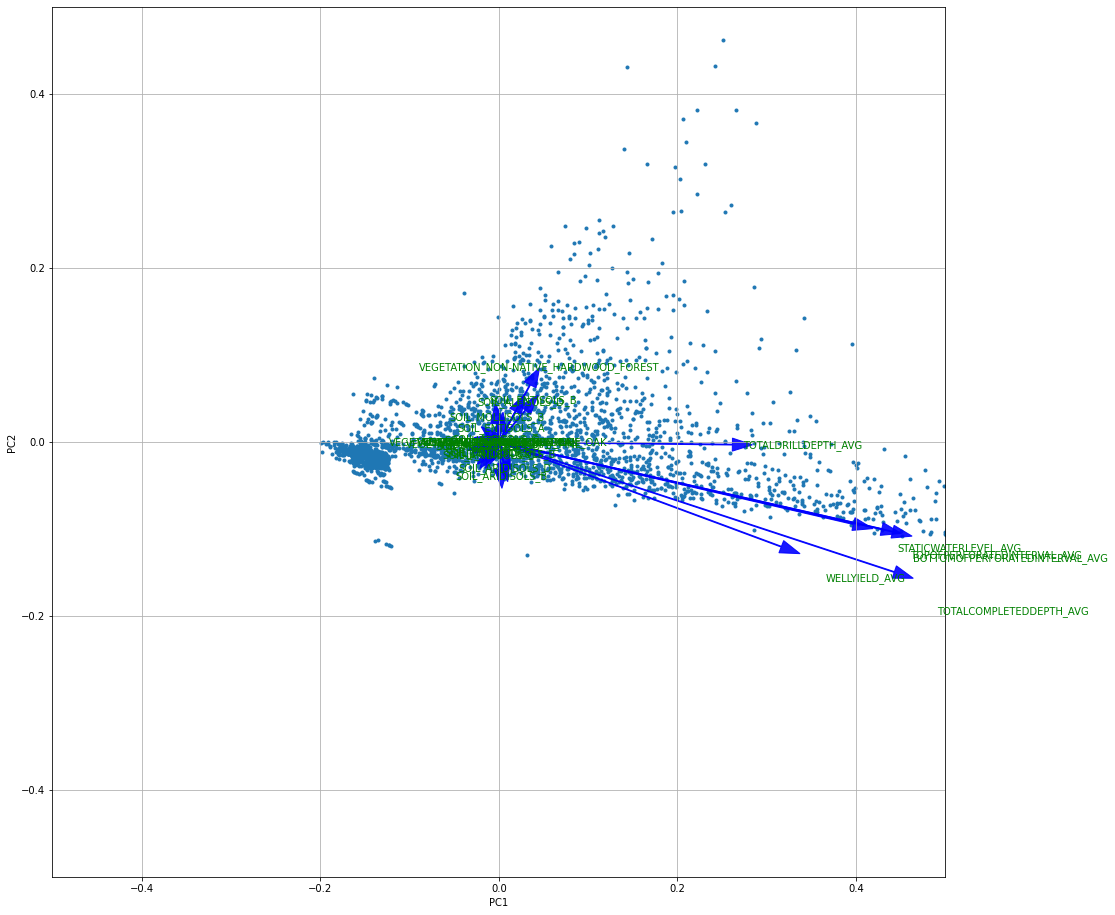

In [ ]:
feature_subset_count = 30
feature_names=list(X_train_impute_df.columns)
feature_subset = slice(0, feature_subset_count, 1)

biplot(X_pca, np.transpose(pca.components_[0:2, feature_subset]), 
       feature_subset_count, 1, 2, labels=feature_names[feature_subset])

   

### Create Dummy regressors and fit on data for baseline

- This can be [scikit-learn dummy regressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)
- It can be a [k-neighbors regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) 

- Create clusters K-Neighbors, Add the column with clusters to the dataset Run regression on it (say RandomForestRegressor)

###  Feature Importance

In [ ]:
col_list = [ col for col in X_train_impute_df if "TOWNSHIP_RANGE" not in col  and 'YEAR' not in col]
rfreg = RandomForestRegressor().fit(X_train_impute_df[col_list], y_train)
draw_feature_importance(col_list, rfreg.feature_importances_)

alt.Chart(...)

In [ ]:
#Store the train and test sets in pickle files

file_exists = os.path.exists('train_test_dict.pickle')

if not file_exists:
    train_test_dict = {"X_train_impute": X_train_impute, 
                      "X_test_impute": X_test_impute,
                      "y_train": y_train,
                      "y_test": y_test,
                }

    with open('train_test_dict.pickle', 'wb') as file:
        pickle.dump(train_test_dict, file)




###  Analyze Shapley Feature Importance

### Unsupervised learning

- Data reduction :
    -  Creates a new nominal level variable that can be used in any further analysis
    - In one-dimension, a good way to quantize real-valued variables into k non-uniform buckets
    - More generally, can be used to compress or summarize large datasets (by replacing data points with their cluster centroids)

- Data Smoothing
   - Infer missing attributes from cluster neighborhoods

- Data understanding
    - Finding underlying factors, groups, structure

- Data navigation
    - Web search and browsing 


### STEPS
Choose an appropriate data representation (PCA)
Select a Distance measure
Select a clustering algorithm
Choose the number of clusters
Interpret the resulting clusters
Assess the quality and validity of clusters 

Iterate aftee the Assessing stage

In [ ]:
#Store the train and test sets in pickle files


file_exists = os.path.exists('train_test_dict.pickle')

##Get the imputed scaled data
if file_exists:
    with open('train_test_dict.pickle', 'rb') as file:
        train_test_dict = pickle.load(file)

    X_train_impute = train_test_dict['X_train_impute']
    X_test_impute = train_test_dict['X_test_impute']
    y_train = train_test_dict['y_train']
    y_test = train_test_dict['y_test']

### Baseline
   - Distribution of the target and statistics such as mean and median 
   - It can be observed below that the target has a [left skewed distribution](https://stats.stackexchange.com/questions/11351/left-skewed-vs-symmetric-distribution-observed/11352#11352) with most well of the groundwater depth less that 200
   - The score of this regressor is very low : R-squared of the prediction = -0.057
   - The r-squared isnegative and this indicates that the the sum-of-squares of the residuals from the model (SSres) is larger than the sum-of-squares from the horizontal line (median) (SStot).
   - R-squared is computed as 1−SSres/SStot. (here, SSres = residual error)When SSres is greater than SStot, that equation could compute a negative value for R-squared, if the value of the coefficient is greater than 1.

In [ ]:
draw_histogram(pd.DataFrame(y_train.reset_index()), "GSE_GWE" ) 

alt.LayerChart(...)

In [ ]:
dummy_regr = DummyRegressor(strategy="median")
lreg = LinearRegression()
rreg = Ridge()
lasreg = Lasso()

predict_score_base_regressors(dummy_regr, X_train_impute, y_train, "Dummy Regressor")
predict_score_base_regressors(lreg, X_train_impute, y_train, "Linear Regressor")
predict_score_base_regressors(rreg, X_train_impuet, y_train, "Ridge Regressor")
predict_score_base_regressors(lasreg, X_train_, y_train, "Lasso Regressor")



Prediction from Dummy Regressor is : [135.47275 135.47275 135.47275 ... 135.47275 135.47275 135.47275]
Train Set Regression Score from Dummy Regressor is : -0.057090827770692965
Prediction from Linear Regressor is : [124.02559817 111.4254949   97.06014597 ... 324.66703306 320.78229306
 320.82513735]
Train Set Regression Score from Linear Regressor is : 0.5595387697659555


NameError: name 'X_train_impuet' is not defined

###  Generative versus Declarative algorithms

### Random searching to narrow down possibilities to provide to GridSearch

Regularization and Generalization for [Lasso](https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression)

When it comes to training models, there are two major problems one can encounter: overfitting and underfitting.

- Overfitting happens when the model performs well on the training set but not so well on unseen (test) data.
- Underfitting happens when it neither performs well on the train set nor on the test set.
Particularly, regularization is implemented to avoid overfitting of the data, especially when there is a large variance between train and test set performances. With regularization, the number of features used in training is kept constant, yet the magnitude of the coefficients is reduced.


**Ridge and Lasso** 

**Lasso Regression for Model Selection**
Lasso is short for Least Absolute Shrinkage and Selection Operator, which is used both for regularization and model selection. If a model uses the L1 regularization technique, then it is called lasso regression. 
Due to the fact that coefficients will be shrunk towards a mean of zero, less important features in a dataset are eliminated when penalized. The shrinkage of these coefficients based on the alpha value provided leads to some form of automatic feature selection, as input variables are removed in an effective approach.

**Ridge regression** puts a similar constraint on the coefficients by introducing a penalty factor. However, while lasso regression takes the magnitude of the coefficients, ridge regression takes the square.
Minimizes objective function:
||y - Xw||^2_2 + alpha * ||w||^2_2


**Scores**
[Negative Mean Absolute Error](https://stackoverflow.com/questions/55786121/what-is-the-negative-mean-absolute-error-in-scikit-learn#:~:text=As%20its%20name%20implies%2C%20negative,than%20a%20value%20of%20%2D3.0%20.) Smaller the better

In [ ]:
rfreg = RandomForestRegressor(
    max_depth=2, n_estimators=200, random_state=RANDOM_SEED
).fit(X_train_impute, y_train)
print(f"Train set score: {rfreg.score(X_train_impute, y_train)}")
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py
print(f"Test set score:{rfreg.score(X_test_impute_df, y_test)}") # without duration = -0.601225986040484

Train set score: 0.373097701276752
Test set score:-0.03730173138387993
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
# random search linear regression model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

model = Lasso()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
# define search space
space = dict()

#space["solver"] = ["svd", "cholesky", "lsqr", "sag"]
#space["solver"] = ["svd"]
space["alpha"] =  [ 1,0.1,0.01,0.001,0.0001]    #loguniform(1e-5, 100)
space["fit_intercept"] = [True, False]
# define search
search = RandomizedSearchCV(
    model,
    space,
    n_iter= 100,  #500,
    scoring= 'r2',    #"neg_median_absolute_error",‘neg_root_mean_squared_error’
    n_jobs=-1,
    cv=cv,
    random_state=RANDOM_SEED,
)
# execute search
train_result = search.fit(X_train_scale, y_train)
# summarize result
print("Best Score: %s" % train_result.best_score_)
print("Best Hyperparameters: %s" % train_result.best_params_)


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Best Score: 0.5352157576643178
Best Hyperparameters: {'fit_intercept': True, 'alpha': 0.001}
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+06, tolerance: 5.521e+03
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
alpha = 0.5
loop = 44
gbrt = GradientBoostingRegressor(
    max_depth=2, n_estimators=loop, learning_rate=alpha, random_state=RANDOM_SEED, init="zero"
)
gbrt.fit(X_train_impute, y_train)
gbrt.loss
y_pred = gbrt.predict(X_test_impute)
r2GBRT = metrics.r2_score(y_test, y_pred)
print("GBT: R^2 = ", r2GBRT)


GBT: R^2 =  -0.43648030010048555


In [ ]:
from  sklearn.svm import SVR



In [ ]:
#from pycaret.regression import *
#We already have an imputed and scaled train and test, we do not want to preprocess
# water_depth_exp = setup(pd.concat([X_train_scale_df, y_train], axis=1), "GSE_GWE",
#                  preprocess=False, session_id=RANDOM_SEED,
#                  log_experiment=True, experiment_name="water_depth_1")
#setup(X_train,y_train)

### Support Vector Machine Regressor

- We will be choosing the parameters first in this case and then run the regression with chosen parameters

In [ ]:
## COmmenting out code since the best parameters have been found
# param_grid = [
#     {
#         "C": [0.5, 1, 10, 100],
#         "gamma": ["scale", 1, 0.1, 0.01, 0.001, 0.0001],
#         "kernel": ["rbf"],
#     }
# ]

# optimal_params = GridSearchCV(
#     SVR(),
#     param_grid,
#     cv=5,
#     scoring='r2',
#     verbose=0
# )
# optimal_params.fit(X_train_impute, y_train)
# print(optimal_params.best_params_)
#{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
svmreg = SVR(C= 100, gamma= 0.01, kernel= 'rbf')
svmreg.fit(X_train_impute, y_train)
print (f"Training Score : {svmreg.score(X_train_impute, y_train)}")
print (f"Testing Score : {svmreg.score(X_test_impute, y_test)}")


Training Score : 0.4618833343933596
Testing Score : 0.15005476507505444


In [ ]:
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error 
# params = {'n_neighbors':[20, 20, 50, 100, 300]}

# knn = KNeighborsRegressor()

# model = GridSearchCV(knn, params, cv=5)
# model.fit(X_train_impute,y_train)
# model.best_params_
#{'n_neighbors': 100}

In [ ]:
knnreg = KNeighborsRegressor(n_neighbors=100)
knnreg.fit(X_train_impute, y_train)
print (f"Training Score : {knnreg.score(X_train_impute, y_train)}")
print (f"Testing Score : {knnreg.score(X_test_impute, y_test)}")

NameError: name 'KNeighborsRegressor' is not defined

#Ideas
1. Drop features such as vegetation and crops and soil
2. Add K Means clustering results

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>